## Simulation of all possible Poker hands

Jacob L. Fine

June 23rd, 2024

In this code, we will implement a Monte Carlo simulation of a large sample of all possible Texas hold'em hands. Texas hold'em is a popular variant of poker, where the player's hand is determined by seven cards: two 'hole cards' delt to each player and five 'community cards'. The player's 'true' hand is the best 5-card subset of the two hold cards plus five community cards. 

This simulation shows that we can estimate the true probabilities of each hand based on a large but non-exhaustive search of all possible hands. We will define the 'error' in our estimation as the absolute difference between each estimated probability and true probability, and output the results in a tabulated format. This also demonstrates the power that computational/numerical methods can have, relative to analytical methods, at estimating parameters with very low error.

We have obtained the true probabilities from Alon (2007): https://www.cs.tau.ac.il/~nogaa/PDFS/skill.pdf

In [11]:
import random
from collections import Counter
from itertools import combinations
import math
from tabulate import tabulate

class TexasHoldemSimulator:
    def __init__(self):
        # Here we define the basis of our card_ranks and suits; use T for 10 since its 1 letter
        self.card_ranks = '23456789TJQKA'
        self.suits = 'CDHS'
        # we generate a deck from card_ranks and suits. 
        self.deck = [r + s for r in self.card_ranks for s in self.suits]
        # Define the possible hands, 52 cards choose 7
        self.total_possible_hands = math.comb(52, 7)
        # The ground truth probabilities obtained from Alon (2007)
        self.true_probabilities = {
            'Royal flush': 4324 / self.total_possible_hands,
            'Straight flush': 37260 / self.total_possible_hands,
            'Four of a kind': 224848 / self.total_possible_hands,
            'Full house': 3473184 / self.total_possible_hands,
            'Flush': 4047644 / self.total_possible_hands,
            'Straight': 6180020 / self.total_possible_hands,
            'Three of a kind': 6461620 / self.total_possible_hands,
            'Two pair': 31433400 / self.total_possible_hands,
            'One pair': 58627800 / self.total_possible_hands,
            'High card': 23294460 / self.total_possible_hands
        }
        # We explictly define the types of hands (for visibility), ranked based on their true frequency of occurrence, except for High card which occurs less than the pairs but is worth less
        self.hand_ranking_list = ['High card', 'One pair', 'Two pair', 'Three of a kind', 'Straight', 'Flush', 'Full house', 'Four of a kind', 'Straight flush', 'Royal flush']



    # A function to determine if our hand is a straight
    def is_straight(self, hand_card_ranks):
        # returns the values of the card ranks in the hand
        rank_values = sorted(self.card_ranks.index(rank) for rank in hand_card_ranks)
        # this allows us to account for the unique case of an ace-low straight, where the ace acts as a 1
        if rank_values == [0, 9, 10, 11, 12]:
            return True
        # if the difference between the first and last rank is 4 and the length of it is 5, after sorting the card_ranks in our hand, it must have been consecutive and thus a straight.
        return len(set(rank_values)) == 5 and rank_values[-1] - rank_values[0] == 4

    # checks if hand is flush
    def is_flush(self, hand_suits):
        # if the set of our hand suits has a length one, there are no other unique suits and thus we have a flush
        return len(set(hand_suits)) == 1

    # a function that will look for specific types of hands based on counts, which we do when the best hand is not a flush, straight flush, royal flush, or straight. 
    # it will return the type of hand name
    def classify_by_rank(self, hand_card_ranks):
        rank_counts = Counter(hand_card_ranks)
        # a list of tuples with (rank, frequency) in our hand, sorted by frequency. 
        most_common = rank_counts.most_common()
        # if the frequency of the most common rank in our hand is 4, we must have four of a kind
        if most_common[0][1] == 4:
            return 'Four of a kind'
        # if the frequency of the most common rank in our hand is 3 and the next most common is 2, we must have a full house. 
        elif most_common[0][1] == 3:
            if most_common[1][1] == 2:
                return 'Full house'
            # If we only have the most common rank occurring three times, we just have three of a kind.
            else:
                return 'Three of a kind'
            # if the top two card_ranks both occur twice, we must have two pairs
        elif most_common[0][1] == 2:
            if most_common[1][1] == 2:
                return 'Two pair'
            # otherwise, if the top element just occurs twice, we have a pair
            else:
                return 'One pair'
            # otherwise, we go with our high card
        return 'High card'

    def evaluate_hand(self, hand):
        hand_card_ranks, hand_suits = zip(*hand)
        # a royal flush occurs if our hand is a flush AND a straight, and the hand card_ranks are the top card_ranks (ten to ace)
        if self.is_flush(hand_suits) and self.is_straight(hand_card_ranks):
            if set(hand_card_ranks) == {'T', 'J', 'Q', 'K', 'A'}:
                return 'Royal flush'
            # all other cases must be straight flushes
            else:
                return 'Straight flush'
        if self.is_flush(hand_suits): 
            return 'Flush'
        if self.is_straight(hand_card_ranks):
            return 'Straight'
        # we apply the function to look for other kinds of hands if these conditions are not met
        return self.classify_by_rank(hand_card_ranks)

    def simulate_texas_holdem(self, num_simulations):
        # initializes the hand counts, which will store {'best_hand': count}
        hand_counts = Counter()
        for _ in range(num_simulations):
            # shuffles the deck each time
            random.shuffle(self.deck)
            hole_cards = self.deck[:2] # takes the first two cards from the deck
            community_cards = self.deck[2:7] # takes the next five cards from the deck
            all_cards = hole_cards + community_cards # the cards to consider are hole cards + community cards
            # the name of the best hand we have, we will update this by exploring the possible best hands in our 5 subset hands from 7 hole + community cards.
            best_hand = 'High card'  
            for possible_hand in combinations(all_cards, 5):
                # we now apply the function to evaluate the current hand. Will return the type of hand it is
                current_hand_name = self.evaluate_hand(possible_hand)
                # we now see where the current hand we return card_ranks in the 'hand_ranking_list' list defined earlier. This uses the standard hand rankings for Texas hold'em.
                if self.hand_ranking_list.index(current_hand_name) > self.hand_ranking_list.index(best_hand):
                    # only if the hand ranking is better than the current best hand, we update the best_hand
                    best_hand = current_hand_name
            # updates the count of a particular hand
            hand_counts[best_hand] += 1

        total_hands = sum(hand_counts.values())
        # normalizes the hand probabilities by their count divided by all hands considered, but doesn't consider high cards
        hand_probabilities_dict = {hand: count / total_hands for hand, count in hand_counts.items() if hand != 'High card'}
        
        return hand_probabilities_dict

# Runs the simulation
num_simulations = 30000
simulator = TexasHoldemSimulator()
estimated_probabilities = simulator.simulate_texas_holdem(num_simulations)

# Arranges the hand types by their probabilities (smallest to largest order)
sorted_probabilities = sorted(estimated_probabilities.items(), key=lambda x: x[1], reverse=True)

# Arranges data for tabulation
table_data = []
for hand, prob in sorted_probabilities:
    true_prob = simulator.true_probabilities.get(hand, 0)
    difference = abs(true_prob - prob) 
    table_data.append([hand, true_prob, prob, difference])

# Tabulates the data and prints the results
print(f'Poker hand frequencies (n={num_simulations} simulations)')
print(tabulate(table_data, headers=['Hand type', 'True prob.', 'Estimated prob.', 'Absolute diff.'], tablefmt='grid'))


Poker hand frequencies (n=30000 simulations)
+-----------------+--------------+-------------------+------------------+
| Hand type       |   True prob. |   Estimated prob. |   Absolute diff. |
+=================+==============+===================+==================+
| One pair        |  0.438225    |       0.433233    |      0.00499212  |
+-----------------+--------------+-------------------+------------------+
| Two pair        |  0.234955    |       0.238567    |      0.0036113   |
+-----------------+--------------+-------------------+------------------+
| Three of a kind |  0.0482987   |       0.0488      |      0.000501302 |
+-----------------+--------------+-------------------+------------------+
| Straight        |  0.0461938   |       0.0456667   |      0.000527154 |
+-----------------+--------------+-------------------+------------------+
| Flush           |  0.0302549   |       0.0295333   |      0.000721608 |
+-----------------+--------------+-------------------+-------------

As can be seen, the difference between true and Monte Carlo estimated probabilities is quite small. We will now explore how different numbers of simulations impact the overall error of our model, in the code below.

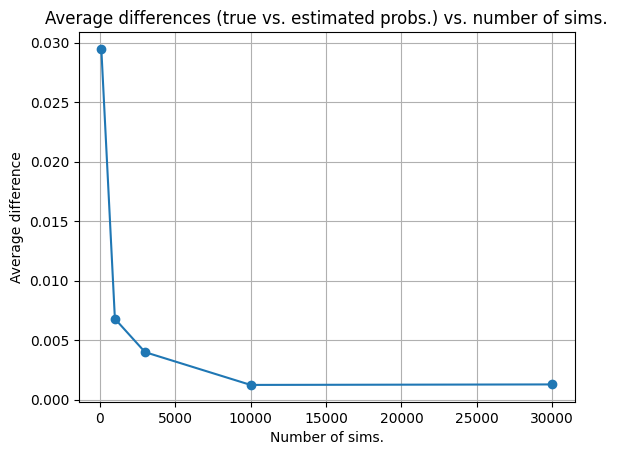

In [6]:
import matplotlib.pyplot as plt

# This is the range of values for # simulations to try
simulation_range = [100, 1000, 3000, 10000, 30000]
# this will store the average difference in probs each time
average_differences = []

# We iterate through the range of possible simulation sizes
for num_simulations in simulation_range:
    # estimates probabilities from each simulation
    estimated_probabilities = simulator.simulate_texas_holdem(num_simulations)

    # Arranges the hand types by their probabilities (smallest to largest order)
    sorted_probabilities = sorted(estimated_probabilities.items(), key=lambda x: x[1], reverse=True)

    # Calculate average difference in probability for this simulation
    total_error = 0
    for hand, prob in sorted_probabilities:
        true_prob = simulator.true_probabilities.get(hand, 0)
        difference = abs(true_prob - prob) 
        total_error += difference
    average_error = total_error / len(sorted_probabilities)

    # Appends average differences to the list, for each simulation. 
    average_differences.append(average_error)

# Plotting
plt.plot(simulation_range, average_differences, marker='o')
plt.xlabel('Number of sims.')
plt.ylabel('Average difference')
plt.title('Average differences (true vs. estimated probs.) vs. number of sims.')
plt.grid(True)
plt.show()


As depicted above, the error (average differnece in true vs. estimated probabilities) approaches zero as the number of simulations increases. 